In [98]:
import gensim
import pandas as pd
import numpy as np
import nltk
import sklearn
import operator
import matplotlib
pd.set_option('display.max_colwidth', -1)

In [99]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
with open('../data/stop_words_en_long.txt', 'r') as f:
    stop_words = f.read()
stop_words = stop_words.split('\n')

In [112]:
df = pd.read_csv('../../data/classification_training.csv')
df.drop(['url', 'Unnamed: 0', 'Unnamed: 0.1', 'langs'], axis=1, inplace=True)

In [312]:
train_cat, test_cat = sklearn.model_selection.train_test_split(df, test_size=0.2)

# Key Word Approach

The first approach is to take key words that might identify the categories and simply count up their occurences in a text. The decision is made on the majority vote.

In [189]:
df_keyword = df.copy()
tokenizer = nltk.tokenize.WordPunctTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
stemmer = nltk.stem.PorterStemmer()

The whole series of texts is tokenized and stemmed.

In [190]:
def prepare_text(text, stop_words):
    tokenizer = nltk.tokenize.WordPunctTokenizer()
    stemmer = nltk.stem.PorterStemmer()
    
    tokens = tokenizer.tokenize(text)
    tokens = [t for t in tokens if len(t) > 2]
    tokens = [t for t in tokens if t not in stop_words] 
    stems = [stemmer.stem(t) for t in tokens]
    stems = [s.lower() for s in stems]
    stems = [s for s in stems if not s.isdigit()]
    
    return stems

In [199]:
keyword_stems_full = df_keyword['text'].map(lambda x: prepare_text(x, stop_words))

These words were obtained by simply reading through the texts and identifying tokens that might uniquely identify disaster or conflict, or appear many times in those categories.

In [196]:
df_keyword['category'].value_counts()

disaster    1710
conflict    854 
other       683 
Name: category, dtype: int64

In [197]:
conflict_tokens = ['war', 'conflict', 'military', 'ceasefire', 'terrorism', 'fighting', 'militia', 'rebels', 
                  'violence', 'violent', 'clash', 'insurgent', 'besiege', 'bomb', 'gun', 'combat', 'siege',
                  'battle', 'battleground', 'explode', 'explosive', 'peace', 'truce', 'airstrike']
conflict_stems = [stemmer.stem(token) for token in conflict_tokens]
disaster_tokens = ['flood', 'wildfire', 'fire', 'earthquake', 'mudslide', 'landslide', 'washed', 'hurricane',
                  'storm', 'rain', 'rainfall', 'river', 'sea', 'disaster', 'volcano', 'typhoon', 'blaze',
                 'tremor', 'drought', 'disease', 'malnutrition', 'virus', 'health', 'tornado', 'forest', 'snow']
disaster_stems = [stemmer.stem(token) for token in disaster_tokens]
print(conflict_stems)
print(disaster_stems)

['war', 'conflict', 'militari', 'ceasefir', 'terror', 'fight', 'militia', 'rebel', 'violenc', 'violent', 'clash', 'insurg', 'besieg', 'bomb', 'gun', 'combat', 'sieg', 'battl', 'battleground', 'explod', 'explos', 'peac', 'truce', 'airstrik']
['flood', 'wildfir', 'fire', 'earthquak', 'mudslid', 'landslid', 'wash', 'hurrican', 'storm', 'rain', 'rainfal', 'river', 'sea', 'disast', 'volcano', 'typhoon', 'blaze', 'tremor', 'drought', 'diseas', 'malnutrit', 'viru', 'health', 'tornado', 'forest', 'snow']


The occurence of each word from the lists are counted and compared.

In [477]:
def tag_by_stem(texts, conflict_stems, disaster_stems):
    equals = []
    categories = []
    tag_dicts = []
    for text in texts:
        tag_dictionary = {'conflict': 0, 'disaster': 0}
        for stem in conflict_stems:
            tag_dictionary['conflict'] = tag_dictionary['conflict'] + text.count(stem)
        for stem in disaster_stems:
            tag_dictionary['disaster'] = tag_dictionary['disaster'] + text.count(stem)
        
        if tag_dictionary['conflict'] == 0 and tag_dictionary['disaster'] == 0:
            category = 'other'
            e = True
        elif tag_dictionary['conflict'] == tag_dictionary['disaster']:
            category = 'unknown'
            e = True
        else:
            category = max(tag_dictionary, key=tag_dictionary.get)
            e = False
        categories.append(category)
        tag_dicts.append(tag_dictionary)
        equals.append(e)
    return categories

In [200]:
manual_tags, tag_dicts, equals = tag_by_stem(keyword_stems_full, conflict_stems, disaster_stems)

In [201]:
print(sklearn.metrics.classification_report(df_manual['category'], manual_tags))

             precision    recall  f1-score   support

   conflict       0.86      0.69      0.77       854
   disaster       0.90      0.89      0.89      1710
      other       0.58      0.71      0.64       683
    unknown       0.00      0.00      0.00         0

avg / total       0.82      0.80      0.81      3247



/Users/George/miniconda3/envs/nlp3/lib/python3.5/site-packages/sklearn/metrics/classification.py:1115: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [202]:
sklearn.metrics.confusion_matrix(df_manual['category'], manual_tags)

array([[ 589,   53,  179,   33],
       [  14, 1516,  166,   14],
       [  82,  114,  484,    3],
       [   0,    0,    0,    0]])

Overall a keyword tagging approach seems to fare reasonably well. The main challenge is misclassification of *disaster* and *conflict* events as *other*.

# Machine Learning Approach

The general machine learning approach used is to convert documents to a TF-IDF representation, and then to mode topcs (or simply reduce dimensionality) by implementing an LSI algorithm. The resulting vectors can then be used in a standard classification technique, such as random forest or SVM.

**Add better text cleaning and combining keyword + ML approaches.**

In [122]:
def prepare_text(text, stop_words):
    tokenizer = nltk.tokenize.WordPunctTokenizer()
    stemmer = nltk.stem.PorterStemmer()
    
    tokens = tokenizer.tokenize(text)
    tokens = [t for t in tokens if len(t) > 2]
    tokens = [t for t in tokens if t not in stop_words] 
    stems = [stemmer.stem(t) for t in tokens]
    stems = [s.lower() for s in stems]
    stems = [s for s in stems if not s.isdigit()]
    
    return stems

In [123]:
def regularize(lsi_vecs):
    mean_vec = lsi_vecs.mean(axis=0)
    std_vec = lsi_vecs.std(axis=0)
    for i, vec in enumerate(lsi_vecs):
        lsi_vecs[i] = (mean_vec - vec) / std_vec
    return lsi_vecs

In [124]:
def lsi_to_vecs(corpus_lsi):
    lsi_vecs = []

    for c in corpus_lsi:
        vec = [x[1] for x in c]
        lsi_vecs.append(vec)

    return np.array(lsi_vecs)

In [282]:
def tfidf_transform(texts, dictionary=None, tfidf_model=None):
    if not dictionary:
        dictionary = gensim.corpora.Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]
    if not tfidf_model:
        tfidf_model = gensim.models.TfidfModel(corpus)
    corpus_tfidf = tfidf_model[corpus]
    return corpus_tfidf, dictionary, tfidf_model

def lsi_transform(corpus_tfidf, dictionary, lsi_model=None, dimensions=2):
    if not lsi_model:
        lsi_model = gensim.models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=dimensions)
    corpus_lsi = lsi_model[corpus_tfidf]
    lsi_vecs = lsi_to_vecs(corpus_lsi)
    return lsi_vecs, corpus_lsi, lsi_model

In [125]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [313]:
train_cat['text'] = train_cat['text'].map(lambda x: prepare_text(x, stop_words))
test_cat['text'] = test_cat['text'].map(lambda x: prepare_text(x, stop_words))

/Users/George/miniconda3/envs/nlp3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/George/miniconda3/envs/nlp3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [249]:
tfidf_train_cat, dictionary_train_cat, cat_tfidf_model = tfidf_transform(train_cat['text'])
lsi_vecs_train_cat_2d, lsi_corpus_train_cat_2d, lsi_model_train_cat_2d = lsi_transform(tfidf_train_cat, dictionary_train_cat)

### 2D Reduction Inspection

In [224]:
topic_0_2d = [x[0][1] for x in lsi_corpus_train_cat_2d]
topic_1_2d = [x[1][1] for x in lsi_corpus_train_cat_2d]

From a 2D dimensionality reduction, it looks like there is some significant separation between the three possible categories.

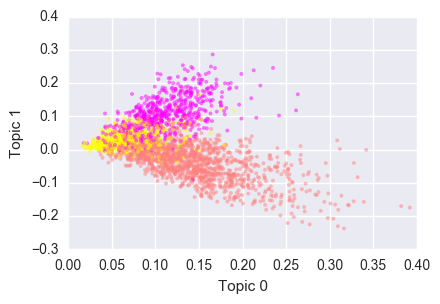

In [227]:
ax = plt.figure(figsize=(4.5,3))
ax = plt.scatter(topic_0_2d, topic_1_2d, c=le.fit_transform(train_labels_cat), alpha=0.5, s=8, linewidth=0)
plt.set_cmap('spring')
plt.xlim((0, 0.4))
plt.xlabel('Topic 0')
plt.ylabel('Topic 1')

## Full LSI

In [323]:
lsi_vecs_train_cat, lsi_corpus_train_cat, lsi_model_train_cat = lsi_transform(tfidf_train_cat, 
                                                                                          dictionary_train_cat, 
                                                                                          dimensions=100)

In [228]:
train_labels_cat = train_cat['category']

In [135]:
from sklearn import naive_bayes
from sklearn.grid_search import GridSearchCV
from sklearn import svm
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier

### Random Forest

In [482]:
param_grid = [{'max_features': [12, 13, 14, 15, 16],
               'n_jobs': [3],
              }]

rf = RandomForestClassifier(n_estimators=1000, n_jobs=3)
clf_cat = model_selection.GridSearchCV(rf, param_grid=param_grid, cv=5)

In [485]:
clf_cat.fit(lsi_vecs_train_cat, train_labels_cat)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=3, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'max_features': [12, 13, 14, 15, 16], 'n_jobs': [3]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [329]:
tfidf_test_cat, dictionary_test_cat, tfidf_model_test_cat = tfidf_transform(test_cat['text'],
                                                                            dictionary=dictionary_train_cat,
                                                                            tfidf_model=cat_tfidf_model)

In [330]:
lsi_vecs_test_cat, lsi_corpus_test_cat, lsi_model_test_cat = lsi_transform(tfidf_test_cat, dictionary_train_cat, lsi_model=lsi_model_train_cat, dimensions=100)

In [494]:
clf_best_cat = clf_cat.best_estimator_

In [495]:
clf_best_cat

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=15, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=3, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [496]:
#predictions = clf_best.predict(lsi_vecs_test_cat_30d)
predictions = clf_best_cat.predict(lsi_vecs_test_cat)

In [491]:
print(sklearn.metrics.classification_report(test_cat['category'], predictions))

             precision    recall  f1-score   support

   conflict       0.98      0.97      0.98       164
   disaster       0.98      0.99      0.99       340
      other       0.97      0.95      0.96       146

avg / total       0.98      0.98      0.98       650



In [344]:
print(sklearn.metrics.confusion_matrix(test_cat['category'], predictions))

[[158   2   4]
 [  0 338   2]
 [  3   4 139]]


### Key Word and RF Combined

We can try to combine the keyword approach with the machine learning approach, to see if the keyword method catches any of the failures made by the classifier.

In [339]:
def combine_predictions(classified, keyword_tagged):
    predictions = []
    for classifier, keyword in zip(classified, keyword_tagged):
        if classifier == keyword:
            predictions.append(keyword)
        elif keyword == 'unknown':
            predictions.append(classifier)
        else:
            predictions.append(classifier)
    return predictions

In [340]:
manual_tags, tag_dicts, equals = tag_by_stem(test_cat['text'], conflict_stems, disaster_stems)

In [341]:
combined_tags = combine_predictions(predictions, manual_tags)

In [342]:
print(sklearn.metrics.classification_report(test_cat['category'], combined_tags))

             precision    recall  f1-score   support

   conflict       0.98      0.96      0.97       164
   disaster       0.98      0.99      0.99       340
      other       0.96      0.95      0.96       146

avg / total       0.98      0.98      0.98       650



In [343]:
print(sklearn.metrics.confusion_matrix(test_cat['category'], combined_tags))

[[158   2   4]
 [  0 338   2]
 [  3   4 139]]


We can see that there is no improvement of combining the keyword approach with the machine learning approach on this particular dataset.

### SVM

In [321]:
param_grid = [{'kernel': ['linear'], 
              'gamma': [.01, .03, 0.1, 0.3, 1.0, 3.0],
              'C': [1/x for x in [.003 , .01, .03, 0.1, 0.3, 1.0, 3.0, 10.0]]}]

svc = svm.SVC()
clf = model_selection.GridSearchCV(svc, param_grid=param_grid, cv=5)

In [322]:
lsi_vecs_train_cat_30d_reg = regularize(lsi_vecs_train_cat_30d)

In [ ]:
clf.fit(lsi_vecs_train_cat_30d, train_labels_cat)

In [263]:
clf.fit(lsi_vecs, train_labels)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'kernel': ['linear'], 'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 3}, {0: 1, 1: 4}, {0: 1, 1: 5}], 'C': [333.3333333333333, 100.0, 33.333333333333336, 10.0, 3.3333333333333335, 1.0, 0.3333333333333333, 0.1], 'gamma': [0.01, 0.03, 0.1, 0.3, 1.0, 3.0]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [259]:
clf_best = clf.best_estimator_

In [260]:
predictions = clf_best.predict(test_lsi_vecs)

In [261]:
print(sklearn.metrics.classification_report(test['category'], predictions))

             precision    recall  f1-score   support

          0       0.77      0.81      0.79       168
          1       0.91      0.97      0.94       348
          2       0.73      0.57      0.64       134

avg / total       0.84      0.85      0.84       650



# Relevance

In [347]:
df_relevance = pd.read_csv('../../data/relevance_training.csv')
df_relevance.drop(['Unnamed: 0'], axis=1, inplace=True)

## Keyword Approach

In [385]:
keyword_stems_rel = df_relevance['text'].map(lambda x: prepare_text(x, stop_words))

These words were obtained by simply reading through the texts and identifying tokens that might uniquely identify disaster or conflict, or appear many times in those categories.

In [384]:
df_relevance['is_displacement'].value_counts()

no     1927
yes    1313
Name: is_displacement, dtype: int64

In [396]:
displacement_tokens = ['evacuated', 'evacuee', 'displaced', 'displacement', 'fled', 'stranded', 'homeless', 
                  'flee', 'rescued', 'trapped', 'shelter', 'camp', 'escape', 'forced', 'migrant', 'run', 'ran']
displacement_stems = [stemmer.stem(token) for token in displacement_tokens]
print(displacement_stems)

['evacu', 'evacue', 'displac', 'displac', 'fled', 'strand', 'homeless', 'flee', 'rescu', 'trap', 'shelter', 'camp', 'escap', 'forc', 'migrant', 'run', 'ran']


In [382]:
def displacement_tag(texts, displacement_stems):
    is_displacement = []
    for text in texts:
        mentions = 0
        for stem in displacement_stems:
            mentions += text.count(stem)
        if mentions > 0:
            is_displacement.append('yes')
        else:
            is_displacement.append('no')
    return is_displacement

In [397]:
is_displacement_keywords = displacement_tag(keyword_stems_rel, displacement_stems)

In [398]:
print(sklearn.metrics.classification_report(df_relevance['is_displacement'], is_displacement_keywords))

             precision    recall  f1-score   support

         no       0.92      0.75      0.82      1927
        yes       0.71      0.90      0.79      1313

avg / total       0.83      0.81      0.81      3240



### Machine Learning Approach

In [348]:
train_rel, test_rel = sklearn.model_selection.train_test_split(df_relevance, test_size=0.2)

In [364]:
train_labels_rel = train_rel['is_displacement']
test_labels_rel = test_rel['is_displacement']

In [352]:
train_rel['text'] = train_rel['text'].map(lambda x: prepare_text(x, stop_words))
test_rel['text'] = test_rel['text'].map(lambda x: prepare_text(x, stop_words))

/Users/George/miniconda3/envs/nlp3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/George/miniconda3/envs/nlp3/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [354]:
tfidf_train_rel, dictionary_train_rel, rel_tfidf_model = tfidf_transform(train_rel['text'])
lsi_vecs_train_rel, lsi_corpus_train_rel, lsi_model_train_rel = lsi_transform(tfidf_train_rel, 
                                                                                          dictionary_train_rel, 
                                                                                          dimensions=100)

#### 2D Reduction Inspection

In [355]:
lsi_vecs_train_rel_2d, lsi_corpus_train_rel_2d, lsi_model_train_rel_2d = lsi_transform(tfidf_train_rel, 
                                                                                          dictionary_train_rel, 
                                                                                          dimensions=2)

In [24]:
lsi_rel_2d = gensim.models.LsiModel(train_rel_corpus_tfidf, id2word=dictionary_rel, num_topics=2)
corpus_rel_lsi_2d = lsi_rel_2d[train_rel_corpus_tfidf]

In [356]:
topic_0_2d = [x[0][1] for x in lsi_corpus_train_rel_2d]
topic_1_2d = [x[1][1] for x in lsi_corpus_train_rel_2d]

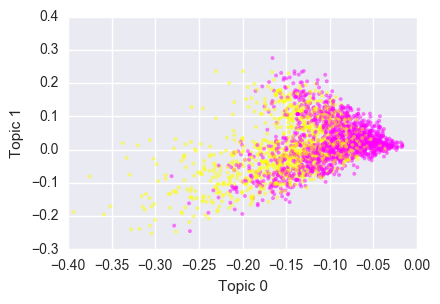

In [362]:
ax = plt.figure(figsize=(4.5,3))
ax = plt.scatter(topic_0_2d, topic_1_2d, c=le.fit_transform(train_rel['is_displacement']), alpha=0.5, s=8, linewidth=0)
plt.set_cmap('spring')
plt.xlim((-0.4, 0))
plt.xlabel('Topic 0')
plt.ylabel('Topic 1')

Much more overlap of the classes when determining whether a text concerns displacement or not.

#### Random Forest

In [363]:
param_grid = [{'max_features': [7, 8, 9, 10, 11, 12],
               'n_jobs': [3],
              }]

rf = RandomForestClassifier(n_estimators=1000, n_jobs=3)
clf = model_selection.GridSearchCV(rf, param_grid=param_grid, cv=5)

In [365]:
clf.fit(lsi_vecs_train_rel, train_labels_rel)

GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=3, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid=[{'max_features': [7, 8, 9, 10, 11, 12], 'n_jobs': [3]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [366]:
tfidf_test_rel, dictionary_test_rel, tfidf_model_test_rel = tfidf_transform(test_rel['text'],
                                                                            dictionary=dictionary_train_rel,
                                                                            tfidf_model=rel_tfidf_model)

In [367]:
lsi_vecs_test_rel, lsi_corpus_test_rel, lsi_model_test_rel = lsi_transform(tfidf_test_rel, dictionary_train_rel, lsi_model=lsi_model_train_rel, dimensions=100)

In [368]:
clf_best = clf.best_estimator_

In [369]:
clf_best

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=12, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=3, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

In [370]:
#predictions = clf_best.predict(lsi_vecs_test_cat_30d)
predictions = clf.predict(lsi_vecs_test_rel)

In [372]:
print(sklearn.metrics.classification_report(test_rel['is_displacement'], predictions))

             precision    recall  f1-score   support

         no       0.78      0.89      0.83       376
        yes       0.81      0.65      0.72       272

avg / total       0.79      0.79      0.78       648



In [383]:
print(sklearn.metrics.confusion_matrix(test_rel['is_displacement'], predictions))

[[334  42]
 [ 96 176]]


#### Keyword and Random Forest Combined

In [449]:
def combine_relevance_tags(classified, keyword_tagged):
    combined = []
    for classifier, keyword in zip(classified, keyword_tagged):
        if keyword == 'no' and classifier == 'no':
            tag = 'no'
        elif keyword == 'yes' and classifier == 'yes':
            tag = 'yes'
        elif keyword == 'no' and classifier == 'yes':
            tag = 'yes'
        elif keyword == 'yes' and classifier == 'no':
            tag = 'yes'
        combined.append(tag)
    return combined

In [450]:
displacement_tags = displacement_tag(test_rel['text'], displacement_stems)

In [451]:
combined_predictions = combine_relevance_tags(predictions, displacement_tags)

In [452]:
print(sklearn.metrics.classification_report(test_rel['is_displacement'], combined_predictions))

             precision    recall  f1-score   support

         no       0.95      0.68      0.80       376
        yes       0.69      0.95      0.80       272

avg / total       0.84      0.80      0.80       648



In [448]:
print(sklearn.metrics.confusion_matrix(test_rel['is_displacement'], combined_predictions))

[[278  98]
 [ 27 245]]


## Predictions on IDMC Test Set

In [460]:
df_idmc_test = pd.read_csv('../../data/test/all_scraped_test_urls.csv')

### Relevance

In a two stage process, we first determine whether an article concerns displacement or not, and then which category it might fall under.

In [465]:
df_idmc_test['text'] = df_idmc_test['Content'].map(lambda x: prepare_text(str(x), stop_words))

Keywords

In [467]:
keyword_relevance = displacement_tag(df_idmc_test['text'], displacement_stems)

Classifier

In [470]:
tfidf_rel, dictionary_rel, tfidf_test_rel = tfidf_transform(df_idmc_test['text'],
                                                            dictionary=dictionary_train_rel,
                                                            tfidf_model=rel_tfidf_model)

In [471]:
lsi_vecs_rel, lsi_corpus_rel, lsi_model_rel = lsi_transform(tfidf_rel, dictionary_train_rel, lsi_model=lsi_model_train_rel, dimensions=100)

In [472]:
classified_relevance = clf.predict(lsi_vecs_rel)

Combined

In [504]:
combined_relevance = combine_relevance_tags(classified_relevance, keyword_relevance)

In [476]:
df_idmc_test['is_displacement'] = combined_relevance

### Category

Keyword

In [479]:
keyword_category = tag_by_stem(df_idmc_test['text'], conflict_stems, disaster_stems)

Classifier

In [497]:
tfidf_cat, dictionary_cat, tfidf_model_cat = tfidf_transform(df_idmc_test['text'],
                                                            dictionary=dictionary_train_cat,
                                                            tfidf_model=cat_tfidf_model)

In [498]:
lsi_vecs_cat, lsi_corpus_cat, lsi_model_cat = lsi_transform(tfidf_cat, dictionary_train_cat, lsi_model=lsi_model_train_cat, dimensions=100)

In [500]:
classified_category = clf_best_cat.predict(lsi_vecs_cat)

Combined

In [501]:
combined_category = combine_predictions(classified_category, keyword_category)

In [502]:
df_idmc_test['category'] = combined_category

### Combine Relevance and Category

In [503]:
def combined_rel_cat(rels, cats):
    tags = []
    for r, c in zip(rels, cats):
        if r == 'no':
            tags.append('not relevant')
        else:
            tags.append(c)
    return tags

In [505]:
final_tags = combined_rel_cat(combined_relevance, combined_category)

In [507]:
df_test = pd.read_csv('../../data/test/IDETECT_test_dataset - Tagging.csv')

In [537]:
df_test['tag'] = final_tags

In [539]:
df_test.to_csv('../../data/tagging_test_output.csv')